#### Layer and Sampling Alignment

This notebook focus in explore the idea that distances from the layers and distances from the non linear activations that arrives from P(s) at fixed time, give us relevant information about variability in phases of HFM.

1) See the distances phenomena in time series 
2) Try to integer it as a order parameter. (Think)
3) See g vs Y to catch something and define which phenomena we are catching. 
4) Do it statistically for large amount of data (Big n, Big J and large amount of repetitions)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math
# --- MODEL HFM ---
def H_model_distribution(n, g):
    all_states = [np.array([int(x) for x in format(i, f'0{n}b')]) for i in range(2**n)]
    # in the state (0, 0, ..., 0) -> ms=0, in state (1, 0, ..., 0) -> ms=1, else =1 is the p(s=(0,0,0))=1
    energies = np.array([np.exp(-g * max(np.max(np.where(s == 1)[0] + 1) - 1, 0)) if np.any(s) else 1.0 for s in all_states])
    Z = np.sum(energies)
    probs = energies / Z
    return all_states, probs

import math

func= "sigmoid"
# Sample from the model
def sample_from_HFM(n, g, T):
    states, probs = H_model_distribution(n, g)
    indices = np.random.choice(len(states), size=T, p=probs)
    samples = np.array([states[i] for i in indices])
    # Transformar 0->-1 y 1->+1
    samples = 2 * samples - 1
    return samples

# Sigmoid Function.
def sigma(x):
    return 1 / (1 + np.exp(-x))

def activation(z, func=func):
    # Options: "step", "sigmoid", "tanh", "relu".
    if func == "step":  # Perceptron
        return np.where(z >= 0, 1.0, -1.0)
    elif func == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif func == "tanh":
        return np.tanh(z)
    elif func == "relu":
        return np.maximum(0.0, z)
    # Podrías agregar "leaky_relu", "elu", etc.
    else:
        raise ValueError("Func no reconocida")

""" 
    w = np.random.normal(loc=0.0, scale=1.0, size=n)
"""

def awareness_layers(S, J=20, eps=0):
    T, n = S.shape
    A = np.zeros((T, J))
    W = np.random.normal(0, 1, (J, n))  # cada layer tiene su propio w^j
    #W = np.ones((T, J))
    for j in range(J):
        # Inicializamos la "conciencia" de la réplica j
        a_j = 0.0
        for t in range(T):
            input_sum = np.dot(W[j], S[t])
            # Aplicamos la función de activación elegida
            out_val = activation(input_sum, func=func)
            # Actualizamos a_j con la dinámica de primer orden
            a_j = (1 - eps) * a_j + eps * out_val
            A[t, j] = a_j
    return A

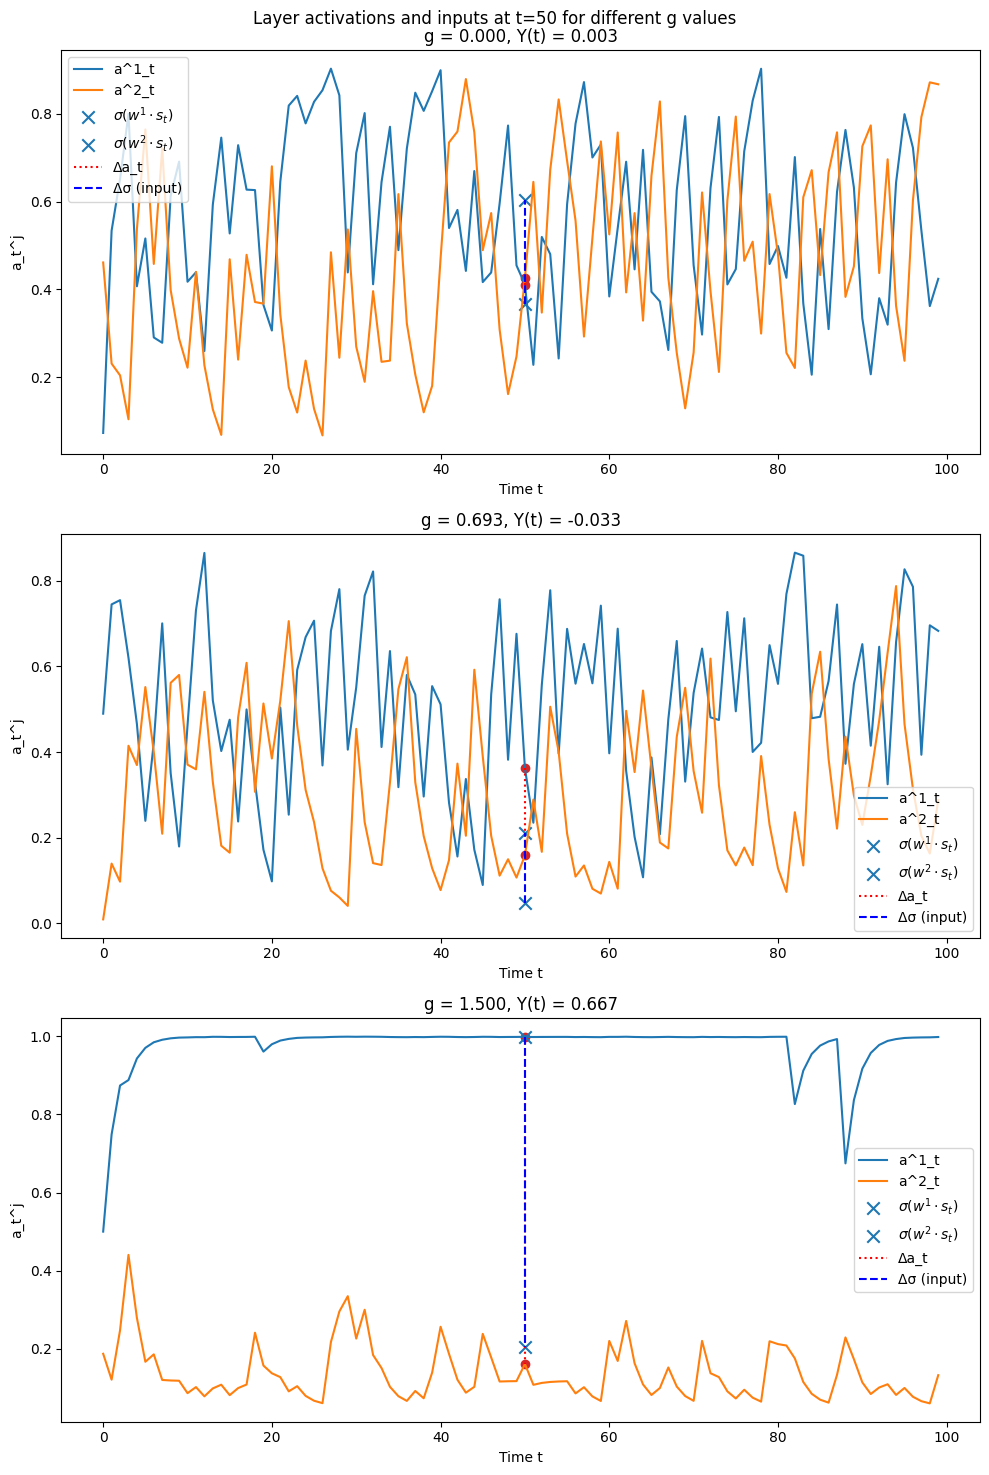

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 10  # number of neuron
T = 100  # time steps 
J = 2  # number of layers
eps = 0.5  # memory parameter
g_values = [0, np.log(2), 1.5]  # different coupling strengths
t_star = 50  # fixed time to measure
func = "sigmoid"

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle(f"Layer activations and inputs at t={t_star} for different g values")

for idx, g in enumerate(g_values):
    # 1) Sample states from HFM
    S = sample_from_HFM(n=n, g=g, T=T)

    # 2) Fixed weights
    W = np.random.normal(0, 1, (J, n))

    # 3) Build activation matrix A
    A = np.zeros((T, J))
    a_vals = np.zeros(J)

    for t in range(T):
        for j in range(J):
            input_sum = np.dot(W[j], S[t])
            sigma_out = activation(input_sum, func=func)
            a_vals[j] = (1 - eps) * a_vals[j] + eps * sigma_out
            A[t, j] = a_vals[j]

    # 4) Calculate sigma inputs at t_star
    sigma_inputs = activation(W @ S[t_star], func=func)
    sig1, sig2 = sigma_inputs[0], sigma_inputs[1]

    # 5) Plot
    ax = axes[idx]
    ax.plot(A[:, 0], label='a^1_t', color='tab:blue')
    ax.plot(A[:, 1], label='a^2_t', color='tab:orange')

    # Mark points and differences
    ax.scatter([t_star], [A[t_star, 0]], color='tab:red')
    ax.scatter([t_star], [A[t_star, 1]], color='tab:red')
    ax.scatter([t_star], [sig1], color='tab:blue', marker='x', s=80, label=r'$\sigma(w^1 \cdot s_t)$')
    ax.scatter([t_star], [sig2], color='tab:blue', marker='x', s=80, label=r'$\sigma(w^2 \cdot s_t)$')
    ax.plot([t_star, t_star], [A[t_star, 0], A[t_star, 1]], color='red', linestyle=':', label='Δa_t')
    ax.plot([t_star, t_star], [sig1, sig2], color='blue', linestyle='--', label='Δσ (input)', linewidth=1.5)

    # Add SRA value
    delta_a = A[t_star, 0] - A[t_star, 1]
    delta_sigma = sig1 - sig2
    sra_value = delta_a * delta_sigma
    ax.set_title(f"g = {g:.3f}, Y(t) = {sra_value:.3f}")
    ax.set_xlabel('Time t')
    ax.set_ylabel('a_t^j')
    ax.legend()

plt.tight_layout()
plt.show()


Let's amplify this calculation to many layers.

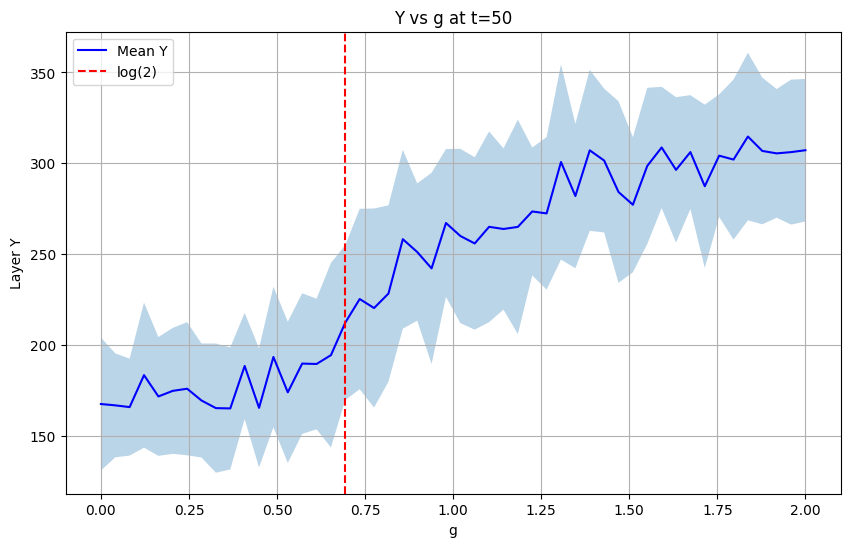

In [38]:
def compute_sra_score(A_t, sigma_inputs):
    """
    A_t: Activaciones en tiempo t, shape (J,)
    sigma_inputs: Entradas puras (sin memoria) en tiempo t, shape (J,)
    """
    J = len(A_t)
    score = 0.0
    for j in range(J):
        for j_prime in range(j + 1, J):
            delta_a = A_t[j] - A_t[j_prime]
            delta_sigma = sigma_inputs[j] - sigma_inputs[j_prime]
            score += delta_a * delta_sigma
    return score

# Parámetros
J = 50  # Número de capas
n_samples = 30  # Número de muestras para promediar
t_fixed = t_star  # Tiempo fijo para analizar
g_values = np.linspace(0, 2, 50)  # Valores de g a evaluar

# Almacenar resultados
mean_sra_scores = np.zeros(len(g_values))
std_sra_scores = np.zeros(len(g_values))

# Para cada valor de g
for i, g_val in enumerate(g_values):
    sra_scores = np.zeros(n_samples)
    
    # Promediar sobre múltiples muestras
    for sample in range(n_samples):
        # Generar nuevos estados y pesos
        S = sample_from_HFM(n=n, g=g_val, T=T)
        W = np.random.normal(0, 1, (J, n))
        A = np.zeros((T, J))
        a_vals = np.zeros(J)

        # Construir activaciones
        for t in range(T):
            for j in range(J):
                input_sum = np.dot(W[j], S[t])
                sigma_out = activation(input_sum, func=func)
                a_vals[j] = (1 - eps) * a_vals[j] + eps * sigma_out
                A[t, j] = a_vals[j]

        # Calcular entradas puras en t_fixed
        sigma_inputs = activation(W @ S[t_fixed], func=func)
        
        # Calcular SRA score
        sra_scores[sample] = compute_sra_score(A[t_fixed], sigma_inputs)
    
    # Guardar media y desviación estándar
    mean_sra_scores[i] = np.mean(sra_scores)
    std_sra_scores[i] = np.std(sra_scores)

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(g_values, mean_sra_scores, 'b-', label='Mean Y')
plt.fill_between(g_values, 
                 mean_sra_scores - std_sra_scores,
                 mean_sra_scores + std_sra_scores,
                 alpha=0.3)
plt.axvline(x=np.log(2), color='r', linestyle='--', label='log(2)')
plt.xlabel('g')
plt.ylabel('Layer Y')
plt.title(f'Y vs g at t={t_fixed}')
plt.legend()
plt.grid(True)
plt.show()
